# OSCAR, a Tech Preview (Part II)
## Wronski Polynomial Systems

* Soprunova & Sottile: Lower bounds for real solutions to sparse polynomial systems, <i>Adv. Math.</i> <b>204</b> (2006).
* Kaluba, Lorenz & Timme: Polymake.jl: A new interface to polymake, <a href="https://arxiv.org/abs/2003.11381">arXiv:2003.11381</a>

In [1]:
using Oscar

$\require{action}$

 -----    -----    -----      -      -----   
|     |  |     |  |     |    | |    |     |  
|     |  |        |         |   |   |     |  
|     |   -----   |        |     |  |-----   
|     |        |  |        |-----|  |   |    
|     |  |     |  |     |  |     |  |    |   
 -----    -----    -----   -     -  -     -  

...combining (and extending) GAP, Hecke, Nemo, Polymake and Singular
Version 0.2.0 ... 
 ... which comes with absolutely no warranty whatsoever
Type: '?Oscar' for more information
(c) 2019-2020 by The Oscar Development Team


We will consider certain systems of polynomial equations which require a regular triangulation of a lattice polytope as (part of its) input.

In [2]:
A = Polymake.polytope.lattice_points(Polymake.polytope.simplex(2,3))
λ = [12,3,0,0,8,1,0,9,5,15];
F = Polymake.polytope.regular_subdivision(A, λ)
TT = Polymake.fan.SubdivisionOfPoints(POINTS = A, MAXIMAL_CELLS = F);

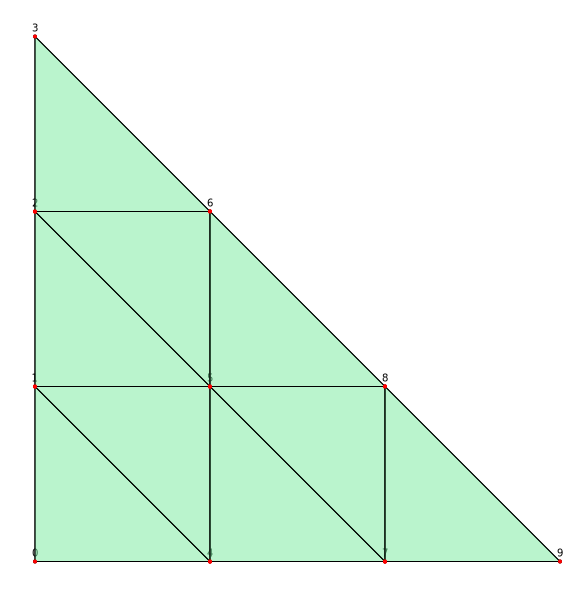

In [3]:
Polymake.display_svg(TT)

This triangulation is very special in that it is <i>foldable</i> (or "balanced"), i.e., the dual graph is bipartite.  This means that the triangles can be colored, say, black and white such that no two triangles of the same color share an edge.  The <i>signature</i> is the absolute difference of the black triangles minus the white triangles (of odd normalized volume).

In [4]:
T = Polymake.topaz.GeometricSimplicialComplex(COORDINATES = A[:,2:end], FACETS = F)
@show T.FOLDABLE
@show T.SIGNATURE

T.FOLDABLE = true
T.SIGNATURE = 3


3

This ideal will be relevant later to check a certain condition, involving the triangulation and some lifting function.  The implementation uses HomotopyContinuation and polymake.

In [5]:
using HomotopyContinuation

function hc_poly(f, vars)
    M = Polymake.monomials_as_matrix(f)
    monomials_as_matrix = [prod(vars.^m) for m in eachrow(M)]
    coeffs = Int.(Polymake.coefficients_as_vector(f))
    sum(map(*, coeffs, monomials_as_matrix))
end;

In [6]:
I = Polymake.polytope.wronski_center_ideal(A, λ)
@polyvar x[1:2] s;
HC_I = [hc_poly(f, [x;s]) for f in I.GENERATORS]

MethodError: MethodError: no method matching Int64(::Polymake.RationalAllocated)
Closest candidates are:
  Int64(::T) where T<:Number at boot.jl:718
  Int64(!Matched::Union{Bool, Int32, Int64, UInt32, UInt64, UInt8, Int128, Int16, Int8, UInt128, UInt16}) at boot.jl:710
  Int64(!Matched::Ptr) at boot.jl:720
  ...

In [ ]:
function wronski_center_ideal(L::AbstractMatrix, λ::AbstractVector)
    d = size(L, 2) - 1
    N = size(L, 1)
    
    T = Polymake.topaz.SimplicialComplex(FACETS=Polymake.polytope.regular_subdivision(L, λ))
    
    proj_orbits = Polymake.common.convert_to{Array{Set{Int}}}(T.PROJ_ORBITS)
    
    colors = Dict([first(o) => i for (i, o) in enumerate(proj_orbits)])
    points_by_color = [Int[] for _ in 0:d]
    for (i, c) in enumerate(T.PROJ_DICTIONARY)
        push!(points_by_color[colors[c]], i)
    end
    
    vars = [["x$i" for i in 1:d]; "s"] # elimination ordering
    R, X = Singular.PolynomialRing(Singular.QQ, vars, ordering = :lex)
    
    # create generators
    monomials = [L[:,2:end] λ]
    Singular.Ideal(R, map(points_by_color) do pts
        M = monomials[pts, :]
        sum(prod(X[j]^Int(M[i, j]) for j in 1:d+1) for i in 1:size(M, 1))
    end)
end

It is a fact that the vertices of a foldable triangulation can be colored by $d+1$ colors (such that vertices of the same color do not share an edge), where $d$ is the dimension.  Here $d=2$.

Now a <i>Wronski polynomial</i> has the given lattice points as exponents, and only one coefficient per color class of vertices of the triangulation.

In [ ]:
function wronski_polynomial(
        M, λ, coeffs, s, X;
        triangulation = Polymake.topaz.SimplicialComplex(FACETS=Polymake.polytope.regular_subdivision(M, λ))
)        
    n = size(M, 1)
    d = size(M, 2)  - 1
    T = triangulation
    m = Dict(f[1] => i for (i, f) in enumerate(T.FACETS[1]))
    full_coeffs = [s^Int(λ[i]) * coeffs[m[T.PROJ_DICTIONARY[i]]] for (i, λᵢ) in enumerate(λ)]
    sum(full_coeffs[i] * prod(X[j]^Int(M[i, j + 1]) for j in 1:d) for i in 1:size(M, 1))
end

A <i>Wronski system</i> consists of $d$ Wronski polynomials with respect to the same lattice points and triangulation.  It is assumed that the coefficients are generic.

In [ ]:
function wronski_system(M, λ, coeffs_vec, s, X;
    triangulation = Polymake.topaz.SimplicialComplex(FACETS=Polymake.polytope.regular_subdivision(M, λ))
)
    map(c -> wronski_polynomial(M, λ, c, s, X; triangulation = triangulation), coeffs)
end

The Wronski center ideal is generated by $d+1$, here 3, polynomials which collect the terms of the color classes and a new variable, $s$, for the lifting function.

In [ ]:
I = wronski_center_ideal(M, λ)
Singular.gens(I)

We compute a Gröbner basis with respect to the lex-ordering.  As this is an elimination ordering, the first polynomial is the eliminant, which is a univariate polynomial in $s$.

In [ ]:
e = first(Singular.gens(Singular.std(I)))

Via Nemo we get a univariate polynomial ring with complex coefficients, which are floating point number with arbitrary precision.

In [ ]:
CC, s = Nemo.PolynomialRing(ComplexField(256), "s")

We are interested in toric solutions; hence we may divide the eliminant by $s^{15}$.

In [ ]:
c = Rational{BigInt}.(Singular.coeffs(e))
exps = last.(Singular.exponent_vectors(e))

# Ignore 0 solutions
exps .-= minimum(exps)

We get 18 complex roots, out of which two are real.  One of the conditions to check asks that there are no real roots between $0$ and $1$.  See the Soprunova-Sottile paper for details.

In [ ]:
roots(sum(c.* s.^exps))

The main result of their paper says that, if all the conditions are satisfied, then a Wronski system has at least signature many real solutions.

In [ ]:
import HomotopyContinuation
HomotopyContinuation.@polyvar x[1:2]

coeffs = [[19,8,-19],[39,7,42]]
W = wronski_system(M, λ, coeffs, 1, x; triangulation = T)

In [ ]:
result = HomotopyContinuation.solve(W)

In [ ]:
HomotopyContinuation.real_solutions(result)

## Visualization (using Sascha's very fresh code)

In [ ]:
using ImplicitPlots
p1 = implicit_plot(W[1])
ImplicitPlots.implicit_plot!(p1, W[2]; color=:indianred)